# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Shakti Estay Pino

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [49]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [50]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-28 02:03:28--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.2’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.06s   

2023-10-28 02:03:28 (11.0 MB/s) - ‘1_digits_train.txt.2’ saved [640604/640604]



In [51]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 02:03:28--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt.2’

1_digits_test.txt.2 100%[===================>] 183.20K  --.-KB/s    in 0.03s   

2023-10-28 02:03:28 (5.49 MB/s) - ‘1_digits_test.txt.2’ saved [187595/187595]



## Leer dataset de dígitos

In [52]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [53]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
#df_train_val

In [54]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
#df_test

In [55]:
#separar los datos entre entranamiento y validación
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)
print("Muestras de entrenamiento: ", len(df_train))
print("Muestras de validación: ", len(df_val))
print("Muestras de prueba: ", len(df_test))
print("Muestras totales: ", len(df_train_val)+len(df_test))

Muestras de entrenamiento:  3042
Muestras de validación:  1305
Muestras de prueba:  1272
Muestras totales:  5619


In [56]:
#normalizar los datos
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-56-d8c268d8e841>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-56-d8c268d8e841>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-56-d8c268d8e841>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

## Crear modelo

In [57]:
# device = torch.device('cuda')
device = torch.device('cpu')
criterion = nn.CrossEntropyLoss()
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Crear datasets y dataloaders para pytorch (train)

In [58]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [59]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

Epoch: 0, train loss: 2.2266, val loss: 2.1381
Epoch: 1, train loss: 2.0305, val loss: 1.9370
Epoch: 2, train loss: 1.8201, val loss: 1.7031
Epoch: 3, train loss: 1.6115, val loss: 1.5059
Epoch: 4, train loss: 1.4153, val loss: 1.3304
Epoch: 5, train loss: 1.2385, val loss: 1.1735
Epoch: 6, train loss: 1.0867, val loss: 1.0148
Epoch: 7, train loss: 0.9612, val loss: 0.9257
Epoch: 8, train loss: 0.8574, val loss: 0.8020
Epoch: 9, train loss: 0.7712, val loss: 0.7362
Epoch: 10, train loss: 0.6973, val loss: 0.6747
Epoch: 11, train loss: 0.6311, val loss: 0.6119
Epoch: 12, train loss: 0.5712, val loss: 0.5621
Epoch: 13, train loss: 0.5187, val loss: 0.5129
Epoch: 14, train loss: 0.4735, val loss: 0.4607
Epoch: 15, train loss: 0.4336, val loss: 0.4264
Epoch: 16, train loss: 0.4000, val loss: 0.4017
Epoch: 17, train loss: 0.3693, val loss: 0.3707
Epoch: 18, train loss: 0.3431, val loss: 0.3519
Epoch: 19, train loss: 0.3214, val loss: 0.3353
Epoch: 20, train loss: 0.3006, val loss: 0.3184
Ep

<ipython-input-73-900884d1b21b>:128: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-73-900884d1b21b>:129: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


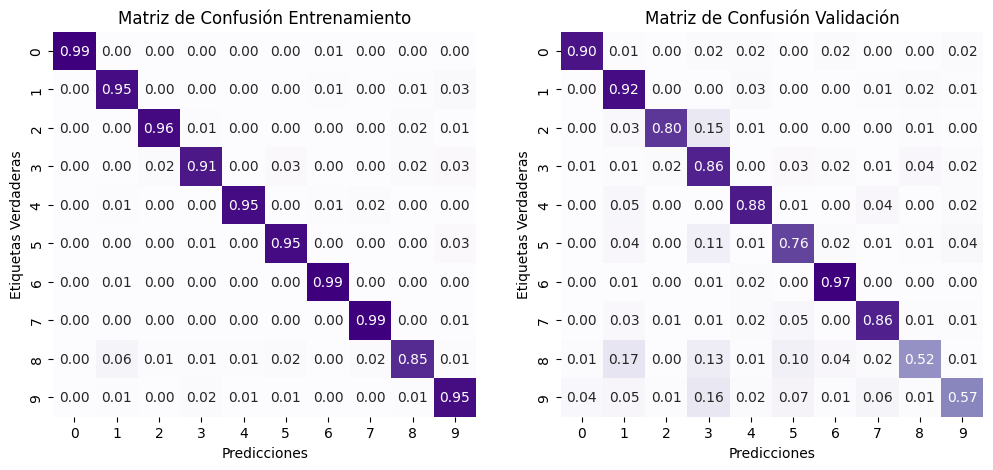

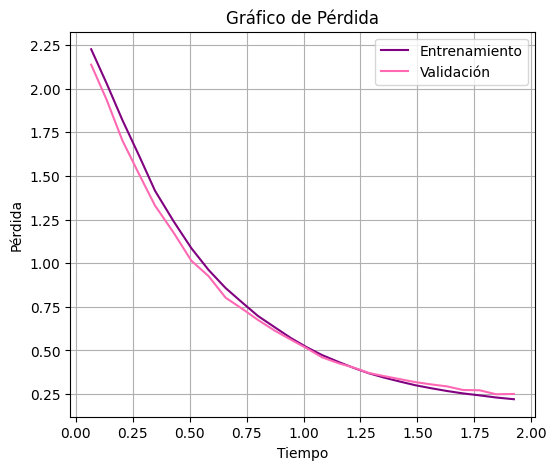

In [73]:
#definir modelo de red neuronal
model_1 = nn.Sequential(
          nn.Linear(64, 10), #capa de entrada 64 y capa oculta 10
          nn.ReLU(),         #funcion de activación
          nn.Linear(10,10)   #capa de salida
        )
model_1 = model_1.to(device)
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = [] #perdida de entrenamiento
loss_val = []   #perdida de validacion
epochs = []     #epocas
train_true=[]   #valor real entrenamiento
train_preds=[]  #prediccion entrenamiento
val_preds=[]    #valor real validacion
val_true=[]     #prediccion validacion
tiempo_list= [] #guardo los tiempos

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_1.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_1(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_1.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_1(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())


  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start               #calculo el tiempo
  epochs.append(epoch)
  tiempo_list.append(tiempo)                 #guardo los valores en una lista

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break


  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_1(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 1: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 1: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()


Epoch: 0, train loss: 2.1663, val loss: 1.9588
Epoch: 1, train loss: 1.7471, val loss: 1.5319
Epoch: 2, train loss: 1.3092, val loss: 1.0943
Epoch: 3, train loss: 0.9226, val loss: 0.7675
Epoch: 4, train loss: 0.6515, val loss: 0.5516
Epoch: 5, train loss: 0.4809, val loss: 0.4246
Epoch: 6, train loss: 0.3751, val loss: 0.3495
Epoch: 7, train loss: 0.3068, val loss: 0.2905
Epoch: 8, train loss: 0.2618, val loss: 0.2671
Epoch: 9, train loss: 0.2289, val loss: 0.2187
Epoch: 10, train loss: 0.2042, val loss: 0.2077
Epoch: 11, train loss: 0.1844, val loss: 0.1888
Epoch: 12, train loss: 0.1691, val loss: 0.1824
Epoch: 13, train loss: 0.1542, val loss: 0.1652
Epoch: 14, train loss: 0.1428, val loss: 0.1567
Epoch: 15, train loss: 0.1331, val loss: 0.1497
Epoch: 16, train loss: 0.1241, val loss: 0.1373
Epoch: 17, train loss: 0.1161, val loss: 0.1310
Detención para evitar sobreajuste
Finished Training, total time 337.972569 seconds
Accuracy de entrenamiento modelo 2:  97.92899408284023 %
Acurac

<ipython-input-72-44123fff93b4>:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-72-44123fff93b4>:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


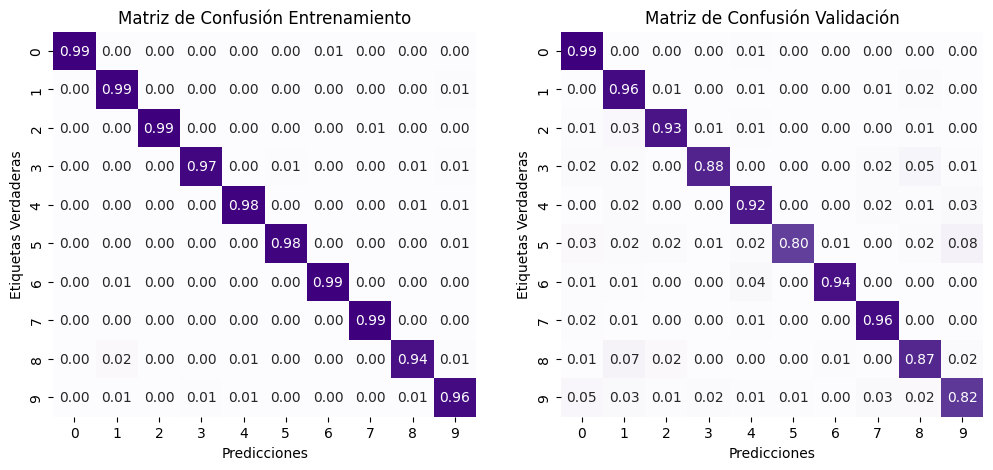

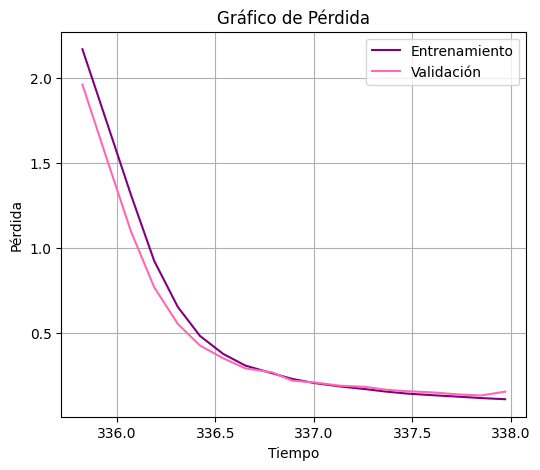

In [72]:
model_2= nn.Sequential(
          nn.Linear(64, 40), #capa de entrada 64 y capa oculta 40
          nn.ReLU(),         #funcion de activación
          nn.Linear(40,10)   #capa de salida
        )
model = model_2.to(device)
optimizer_1 = torch.optim.Adam(model_2.parameters(), lr=1e-3)

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
train_true=[] #valor real
train_preds=[] #prediccion
val_preds=[]
val_true=[]
tiempo_list= [] #guardo los tiempos

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_2.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer_1.zero_grad()
    # forward + backward + optimize
    outputs = model_2(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer_1.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_2.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_2(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())
  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start
  epochs.append(epoch)
  tiempo_list.append(tiempo)

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_2(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 2: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 2: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()


Epoch: 0, train loss: 2.1482, val loss: 2.0193
Epoch: 1, train loss: 1.9210, val loss: 1.8142
Epoch: 2, train loss: 1.7330, val loss: 1.6376
Epoch: 3, train loss: 1.5735, val loss: 1.5034
Epoch: 4, train loss: 1.4342, val loss: 1.3638
Epoch: 5, train loss: 1.3104, val loss: 1.2506
Epoch: 6, train loss: 1.1977, val loss: 1.1473
Epoch: 7, train loss: 1.0964, val loss: 1.0617
Epoch: 8, train loss: 1.0036, val loss: 0.9627
Epoch: 9, train loss: 0.9209, val loss: 0.8764
Epoch: 10, train loss: 0.8451, val loss: 0.8098
Epoch: 11, train loss: 0.7779, val loss: 0.7471
Epoch: 12, train loss: 0.7173, val loss: 0.6939
Epoch: 13, train loss: 0.6627, val loss: 0.6337
Epoch: 14, train loss: 0.6158, val loss: 0.5882
Epoch: 15, train loss: 0.5718, val loss: 0.5537
Epoch: 16, train loss: 0.5332, val loss: 0.5173
Epoch: 17, train loss: 0.4995, val loss: 0.4951
Epoch: 18, train loss: 0.4688, val loss: 0.4521
Epoch: 19, train loss: 0.4417, val loss: 0.4467
Epoch: 20, train loss: 0.4158, val loss: 0.4040
Ep

<ipython-input-71-46d6250da78d>:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-71-46d6250da78d>:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


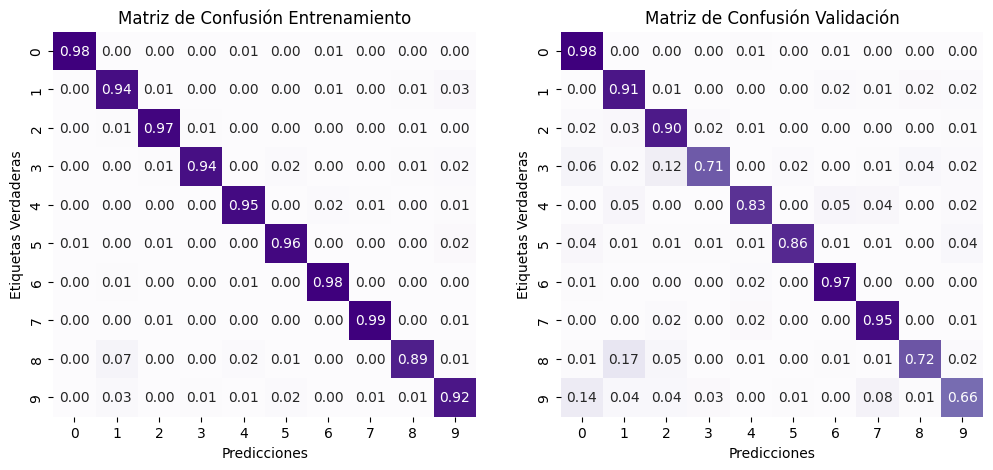

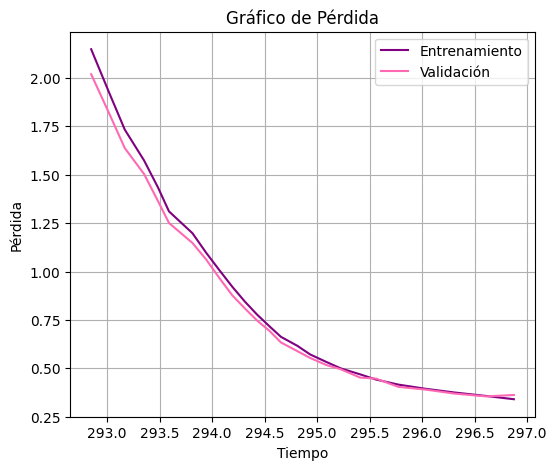

In [71]:
model_3= nn.Sequential(
          nn.Linear(64, 10), #capa de entrada 64 y capa oculta 10
          nn.Tanh(),         #funcion de activación
          nn.Linear(10,10)   #capa de salida
        )
model_3 = model_3.to(device)
optimizer_1= torch.optim.Adam(model_3.parameters(), lr=1e-3)

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
train_true=[] #valor real
train_preds=[] #prediccion
val_preds=[]
val_true=[]
tiempo_list=[]

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_3.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer_1.zero_grad()
    # forward + backward + optimize
    outputs = model_3(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer_1.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_3.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_3(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())
  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start
  epochs.append(epoch)
  tiempo_list.append(tiempo)

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_3(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 3: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 3: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()

Epoch: 0, train loss: 1.9820, val loss: 1.7058
Epoch: 1, train loss: 1.4763, val loss: 1.2487
Epoch: 2, train loss: 1.0989, val loss: 0.9386
Epoch: 3, train loss: 0.8299, val loss: 0.7249
Epoch: 4, train loss: 0.6404, val loss: 0.5725
Epoch: 5, train loss: 0.5093, val loss: 0.4676
Epoch: 6, train loss: 0.4196, val loss: 0.3900
Epoch: 7, train loss: 0.3545, val loss: 0.3417
Epoch: 8, train loss: 0.3060, val loss: 0.2973
Epoch: 9, train loss: 0.2719, val loss: 0.2715
Epoch: 10, train loss: 0.2418, val loss: 0.2535
Epoch: 11, train loss: 0.2191, val loss: 0.2238
Epoch: 12, train loss: 0.2010, val loss: 0.2121
Epoch: 13, train loss: 0.1851, val loss: 0.1899
Epoch: 14, train loss: 0.1715, val loss: 0.1882
Epoch: 15, train loss: 0.1605, val loss: 0.1801
Epoch: 16, train loss: 0.1505, val loss: 0.1605
Epoch: 17, train loss: 0.1417, val loss: 0.1599
Epoch: 18, train loss: 0.1339, val loss: 0.1554
Epoch: 19, train loss: 0.1267, val loss: 0.1469
Epoch: 20, train loss: 0.1202, val loss: 0.1404
De

<ipython-input-70-4709d64ec44b>:122: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-70-4709d64ec44b>:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


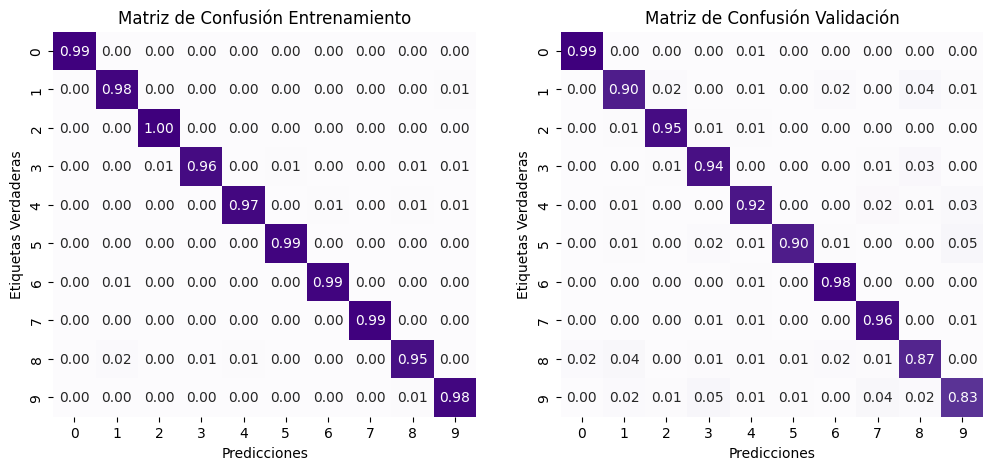

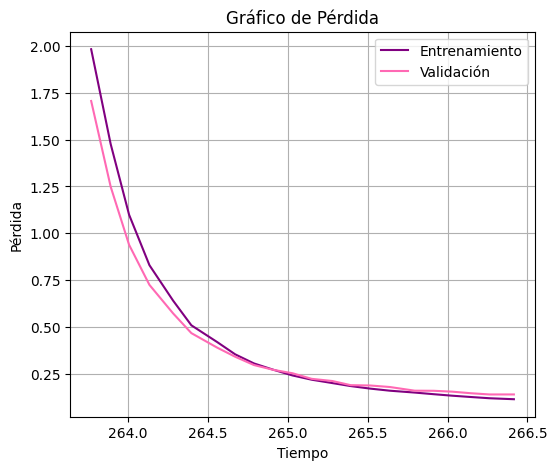

In [70]:
model_4=nn.Sequential(
          nn.Linear(64, 40), #capa de entrada 64 y capa oculta 40
          nn.Tanh(),         #funcion de activación
          nn.Linear(40,10)   #capa de salida
        )
model_4 = model_4.to(device)
optimizer_1 = torch.optim.Adam(model_4.parameters(), lr=1e-3)

loss_train = []
loss_val = []
epochs = []
train_true=[] #valor real
train_preds=[] #prediccion
val_preds=[]
val_true=[]
tiempo_list=[]

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_4.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer_1.zero_grad()
    # forward + backward + optimize
    outputs = model_4(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer_1.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_4.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_4(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())
  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start               #calculo el tiempo
  epochs.append(epoch)
  tiempo_list.append(tiempo)                 #lo agrego a una lista

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_4(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 4: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 4: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()

Epoch: 0, train loss: 2.2898, val loss: 2.2394
Epoch: 1, train loss: 2.1805, val loss: 2.1057
Epoch: 2, train loss: 2.0282, val loss: 1.9360
Epoch: 3, train loss: 1.8296, val loss: 1.7300
Epoch: 4, train loss: 1.6200, val loss: 1.5135
Epoch: 5, train loss: 1.4269, val loss: 1.3438
Epoch: 6, train loss: 1.2499, val loss: 1.1726
Epoch: 7, train loss: 1.0844, val loss: 1.0163
Epoch: 8, train loss: 0.9338, val loss: 0.8783
Epoch: 9, train loss: 0.7967, val loss: 0.7396
Epoch: 10, train loss: 0.6788, val loss: 0.6161
Epoch: 11, train loss: 0.5829, val loss: 0.5370
Epoch: 12, train loss: 0.5033, val loss: 0.4655
Epoch: 13, train loss: 0.4413, val loss: 0.4538
Epoch: 14, train loss: 0.3951, val loss: 0.3714
Epoch: 15, train loss: 0.3568, val loss: 0.3448
Epoch: 16, train loss: 0.3276, val loss: 0.3204
Epoch: 17, train loss: 0.3020, val loss: 0.3003
Epoch: 18, train loss: 0.2811, val loss: 0.2888
Epoch: 19, train loss: 0.2633, val loss: 0.2722
Detención para evitar sobreajuste
Finished Trainin

<ipython-input-69-5dd8a67f4bb3>:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-69-5dd8a67f4bb3>:125: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


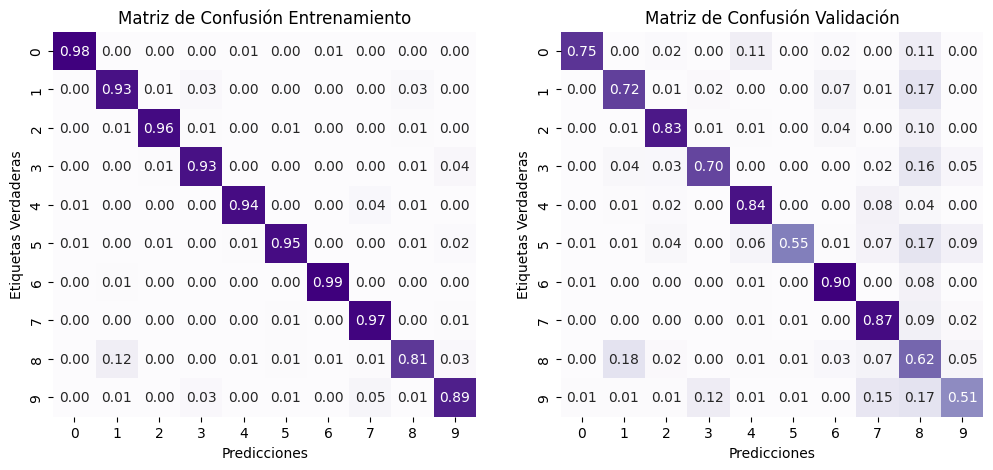

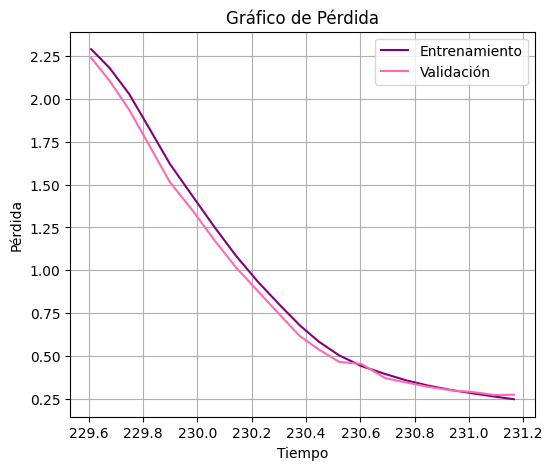

In [69]:
model_5= nn.Sequential(
          nn.Linear(64, 10), #capa de entrada 64 y capa oculta 10
          nn.ReLU(),         #funcion de activación
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,10)
        )
model_5 = model_5.to(device)
optimizer_1 = torch.optim.Adam(model_5.parameters(), lr=1e-3)

loss_train = []
loss_val = []
epochs = []
train_true=[] #valor real
train_preds=[] #prediccion
val_preds=[]
val_true=[]
tiempo_list=[]

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_5.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer_1.zero_grad()
    # forward + backward + optimize
    outputs = model_5(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer_1.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_5.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_5(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())
  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start
  epochs.append(epoch)
  tiempo_list.append(tiempo)

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_5(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 5: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 5: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()

Epoch: 0, train loss: 2.2055, val loss: 2.0559
Epoch: 1, train loss: 1.8456, val loss: 1.5519
Epoch: 2, train loss: 1.2298, val loss: 0.8996
Epoch: 3, train loss: 0.6762, val loss: 0.4957
Epoch: 4, train loss: 0.3835, val loss: 0.3288
Epoch: 5, train loss: 0.2632, val loss: 0.2428
Epoch: 6, train loss: 0.2042, val loss: 0.2052
Epoch: 7, train loss: 0.1668, val loss: 0.1727
Epoch: 8, train loss: 0.1424, val loss: 0.1507
Epoch: 9, train loss: 0.1245, val loss: 0.1411
Epoch: 10, train loss: 0.1107, val loss: 0.1307
Epoch: 11, train loss: 0.0992, val loss: 0.1238
Epoch: 12, train loss: 0.0890, val loss: 0.1138
Detención para evitar sobreajuste
Finished Training, total time 179.299282 seconds
Accuracy de entrenamiento modelo 6:  98.19197896120973 %
Acuracy de validación modelo 6:  90.21346469622333 %


<ipython-input-67-b23bdcb19c52>:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
<ipython-input-67-b23bdcb19c52>:125: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")


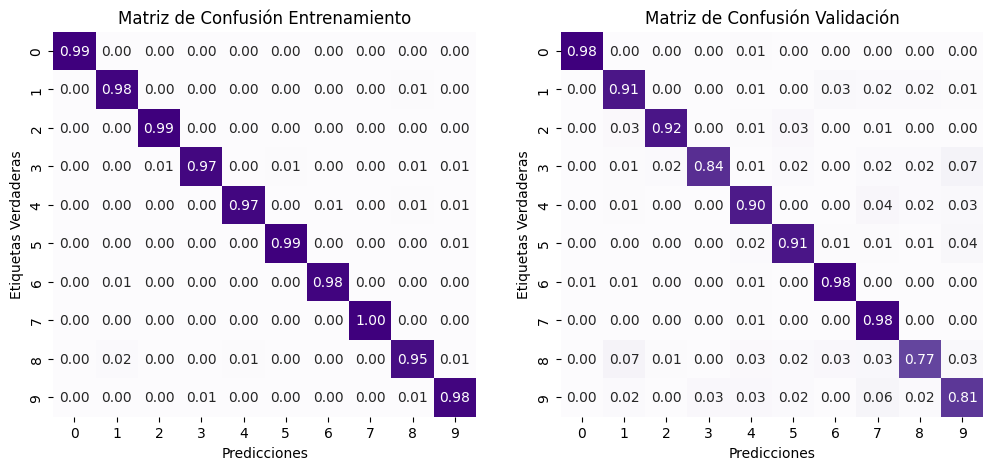

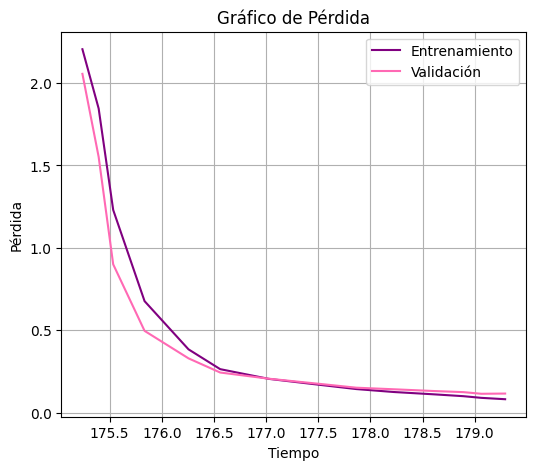

In [67]:
model_6= nn.Sequential(
          nn.Linear(64, 40), #capa de entrada 64 y capa oculta 40
          nn.ReLU(),         #funcion de activación
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,10)
        )
model_6 = model_6.to(device)
optimizer_1 = torch.optim.Adam(model_6.parameters(), lr=1e-3)

loss_train = []
loss_val = []
epochs = []
train_true=[] #valor real
train_preds=[] #prediccion
val_preds=[]
val_true=[]
tiempo_list=[]

#evitar el sobreajuste
early_stopping= EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights= True)
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model_6.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer_1.zero_grad()
    # forward + backward + optimize
    outputs = model_6(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer_1.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_6.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_6(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
      val_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
      val_true.extend(labels.cpu().numpy())
  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  tiempo = time.time() - start
  epochs.append(epoch)
  tiempo_list.append(tiempo)

  if epoch > 0: #verificar si se detiene el entrenamiento
    if loss_val[epoch]> loss_val[epoch-1]:
      print("Detención para evitar sobreajuste")
      break

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

with torch.no_grad():

    for i, data in enumerate(dataloader_train, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_6(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy de entrenamiento modelo 6: ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
#Calculamos la Matriz de Confusión entrenamiento
matriz_ = confusion_matrix(val_true,val_preds, normalize = "true")
#matriz de confusion de validacion
acu_val= accuracy_score(val_preds,val_true)
print("Acuracy de validación modelo 6: ", acu_val*100, "%")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(matriz_1, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[0])

axes[0].set_title('Matriz de Confusión Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Etiquetas Verdaderas')
sns.heatmap(matriz_, annot=True, fmt='.2f', cmap='Purples', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusión Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Etiquetas Verdaderas')

#grafico de perdida
plt.figure(figsize = (6, 5))
plt.title("Gráfico de Pérdida")
plt.xlabel("Tiempo")
plt.ylabel("Pérdida")
plt.plot(tiempo_list, loss_train, "b", label = "Entrenamiento", color = "purple")
plt.plot(tiempo_list, loss_val, "r", label = "Validación", color = "hotpink")
plt.grid()
plt.legend()

PARTE 3

Accuracy  97.72832637923041 %


Text(0.5, 1.0, 'Matriz de Confusión Normalizada')

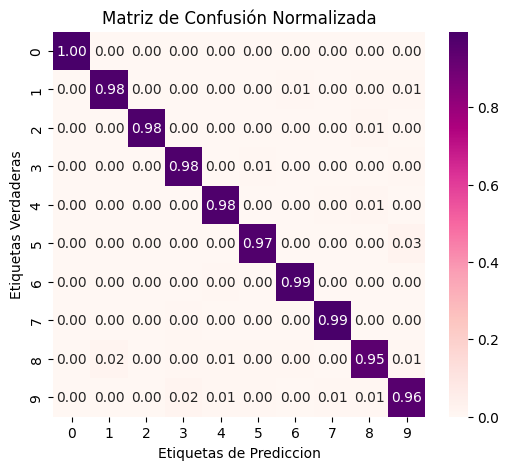

In [66]:
with torch.no_grad():

    for i, data in enumerate(dataloader_test, 0):
        #Procesamos batch actual:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model_4(inputs)

        #Obtenemos las etiquetas predichas:
        predicted = torch.argmax(outputs, dim=1)

        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

acu_train= accuracy_score(train_preds,train_true)
print("Accuracy ", acu_train*100, "%")
#Calculamos la Matriz de Confusión entrenamiento
matriz_1 = confusion_matrix(train_true,train_preds, normalize = "true")
plt.figure(figsize=(6, 5))
sns.heatmap(matriz_1, annot = True, cmap = "RdPu", fmt = ".2f")
plt.xlabel("Etiquetas de Prediccion")
plt.ylabel("Etiquetas Verdaderas")
plt.title(f"Matriz de Confusión Normalizada")